In [123]:
%run imports/VacuumGauge_functions.ipynb
%run imports/rbflayer.py

import pandas as pd
import numpy as np
import joblib
import tensorflow as tf
from tensorflow import keras

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')


root_logdir = os.path.join(os.curdir, 'data/logs')

if not(os.path.exists(root_logdir)):
    !mkdir -p {root_logdir}
    print('{} succesfully created.'.format(root_logdir))
else:
    print('{} already exist.'.format(root_logdir))

def get_run_logdir(model_version):
    import time
    run_id = time.strftime('{}_run_%Y_%m_%d-%H_%M_%S'.format(model_version))
    return os.path.join(root_logdir, run_id)

./data/logs already exist.


### Tensorboard starting -- (only if needed)

In [162]:
%load_ext tensorboard
%tensorboard --logdir={root_logdir} --port=6006

## Reading the dataset

- df_ok: labels of ok gauges
- df_delta: labels of delta gauges
- df_ raw: raw data cointaining the full reading of each gauge

In [2]:
df_delta = pd.read_csv('data/datasets/df_delta.csv') # cointains labels for delta VG
df_ok = pd.read_csv('data/datasets/df_ok.csv')  #contains labels for ok VG

df_raw = pd.read_csv('data/datasets/df_raw.csv') ## contains full reading of each VG

df_labels = pd.concat([df_ok, df_delta], sort=False, axis=0)


df_VG = pd.merge(df_raw, df_labels, on =['gauge_id','fillNumber'])
df_VG = df_VG.set_index(['gauge_id','fillNumber'], drop=True)

## Removing categorical values
df_VG.y.replace(to_replace=['ok', 'delta'], value=[0, 1], inplace=True)

## Splitting the dataset in input and target
- X are the input features
- y is the target vector

Definition of a StratifiedKFold split to be used in all the grid searchs for all the model: 

In [3]:
X = np.array(df_VG.iloc[:, :-1])
y = np.array(df_VG.iloc[:, -1])

from sklearn.model_selection import StratifiedKFold

strat_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## Hold out a test set for final evaluation

In [ ]:
# from sklearn.model_selection import StratifiedShuffleSplit


# sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# print(sss)

# for train_index, test_index in sss.split(X, y):
#     print("TRAIN size:", len(train_index), "TEST size:", len(test_index))
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]


# print(len(y_train))
# print(sum(y_train))
# print(len(y_test))
# print(sum(y_test))

## Preprocessing

The preprocessing of the input is divided in 3 steps:

1. Max pooling layer with kernel 15 and strides 15: reduce the dimensionality of a factor 15 keeping the max values, it preserve the interesting part of the signal
2. Median filter with kernel 9 to get rid of evenutally present white noise
3. Savitzky–Golay filter to further reduce discontinuities
4. Scaling of each time series to help gradient descent converge

In [ ]:
import scipy
from skimage.measure import block_reduce

## Tensorflow implementation of max_pool

# X_max = X.reshape((X.shape[0], 3000, 1))  
# X_max = tf.nn.max_pool1d(X_max, ksize=15, strides=15, padding='VALID')
# X_max = X_max[...,0]

## Numpy implementation of max_pool

X_max = block_reduce(X, block_size=(1,15), func=np.max)


X_med = np.apply_along_axis(scipy.signal.medfilt, axis=1, arr= X_max, kernel_size=9)
X_sav = np.apply_along_axis(scipy.signal.savgol_filter, axis=1,
                            arr= X_med, window_length=11, polyorder=2)
scaler = RowScaler(scaling_method='Standard')

pca = PCA(n_components=30)
X_norm = scaler.fit_transform(X_sav)
X_pca = pca.fit_transform(X_norm)



# X_f = np.fft.fft(X_avg, X_avg.shape[-1])
# X_f = np.fft.fftshift(X_f, axes=-1)
X_pca.shape

In [ ]:
# g = np.gradient(X_norm, axis=1)
# for i in range(0, 20, 1):
#     plt.plot(X_norm[i])
#     plt.plot(g[i]/np.max(g[i]))
#     plt.show()

In [ ]:
%matplotlib inline
for i in range(0,12):
    plt.subplot(4,1,1)
    plt.plot(X[i])
    plt.subplot(4,1,2)
    plt.plot(X_med[i])
    plt.subplot(4,1,3)
    plt.plot(X_sav[i])
    plt.subplot(4,1,4)
    plt.plot(g[i])
    plt.tight_layout()
    plt.show()

## Quick overview on the PCA impact

PCA performed on the trainig part of the normalised dataset to visualize its impact.

In [ ]:

scaler = RowScaler('Standard')
# X_norm = scaler.fit_transform(X)
# X_norm[0].shape

i=100
X_m = scaler.fit_transform(X) - scaler.fit_transform(X).mean(axis=0, keepdims=0)
plt.figure()
plt.plot(range(3000), scaler.fit_transform(X)[i])
plt.plot(range(3000), X_m[i])
plt.show()

In [ ]:
preprocess = Prepocess(log_scale=False)
scaler = RowScaler('Standard')

pca = PCA(n_components=3)


X_pca = pca.fit_transform(scaler.fit_transform(preprocess.fit_transform(X)))
# X_pca = pca.fit_transform(scaler.fit_transform(X))
X_pca[1]

In [ ]:
%matplotlib inline

fontsize=15

ok = X_pca[y==0]
delta = X_pca[y ==1]


plt.style.use('seaborn-whitegrid')
fontsize=20

plt.figure(figsize=(10,8))
plt.scatter(ok[:,0], ok[:,1], c='b', label='no heating', s=50)
plt.scatter(delta[:,0], delta[:,1], c='r', label='heating', s=50)

plt.legend(fontsize=fontsize)
plt.xlabel('component #1', fontsize=fontsize)
plt.ylabel('component #2', fontsize=fontsize)
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.grid(True)
plt.show()

plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(10,8))
ax = Axes3D(fig)

ax.scatter(ok[:,0], ok[:,1], ok[:,2], c='b', label='no heating', s=50)
ax.scatter(delta[:,0], delta[:,1], delta[:,2], c='r', label='heating', s=50)

ax.set_xlabel('component #1', fontsize=fontsize)
ax.set_ylabel('component #2', fontsize=fontsize)
ax.set_zlabel('component #3', fontsize=fontsize)

# ax.set_xlim(-25,30)
# ax.set_ylim(-5,20)
# ax.set_zlim(-10,7.5)
plt.gca().patch.set_facecolor('white')
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.legend(fontsize=fontsize)
plt.show()


In [ ]:
index = np.where(np.all([y == 1, X_pca[:,0]>5], axis=0))

## K-MEANS preprocessing

In [ ]:
from sklearn.decomposition import KernelPCA
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import TSNE

preprocess = Prepocess(log_scale=False)
scaler = RowScaler('Standard')

kmeans = KMeans(n_clusters=3,
                algorithm='elkan',
                random_state=42)
lle = LocallyLinearEmbedding(n_components=3, n_neighbors= 10)
rbf_pca = KernelPCA(n_components=3, kernel='rbf', gamma=0.005)
tsne = TSNE(n_components=3, perplexity=20)
a = preprocess.fit_transform(X)
b = scaler.fit_transform(a)
d = kmeans.fit_transform(b)
# d = rbf_pca.fit_transform(c)

In [ ]:
d.shape

In [ ]:
# for center in kmeans.cluster_centers_:
#     plt.plot(range(200), center)
#     plt.show()

In [ ]:
%matplotlib qt
ok = d[y==0]
delta = d[y ==1]


plt.style.use('seaborn-whitegrid')
fontsize=20
plt.close('all')
plt.figure(figsize=(10,8))
plt.scatter(ok[:,0], ok[:,1], c='b', label='no heating', s=50)
plt.scatter(delta[:,0], delta[:,1], c='r', label='heating', s=50)

plt.legend(fontsize=fontsize)
plt.xlabel('component #1', fontsize=fontsize)
plt.ylabel('component #2', fontsize=fontsize)
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.grid(True)
plt.show()

plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(10,8))
ax = Axes3D(fig)

ax.scatter(ok[:,0], ok[:,1], ok[:,2], c='b', label='no heating', s=50)
ax.scatter(delta[:,0], delta[:,1], delta[:,2], c='r', label='heating', s=50)

ax.set_xlabel('component #1', fontsize=fontsize)
ax.set_ylabel('component #2', fontsize=fontsize)
ax.set_zlabel('component #3', fontsize=fontsize)

# ax.set_xlim(-25,30)
# ax.set_ylim(-5,20)
# ax.set_zlim(-10,7.5)
plt.gca().patch.set_facecolor('white')
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.legend(fontsize=fontsize)
plt.show()

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = Pipeline([
    ('preprocessor', Prepocess()),
    ('scaler', RowScaler(scaling_method='Standard')),
    ('kmeans', KMeans(algorithm='elkan',random_state=42)),
    ('forest', RandomForestClassifier())

])

model = forest_clf
model_dir = 'data/models/random_forest'
model_version = 'forest_006.pkl'
scoring = ['recall', 'accuracy', 'precision']

forest_path = os.path.join(model_dir, model_version)

print(os.path.join(model_dir,model_version))

#### GridSearch

In [ ]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
a = Real(2,100, prior='log-uniform')
# b = Real(1,100)
X = range(1,1000)
plt.plot((sorted(a.rvs(100))))
# plt.plot(sorted(b.rvs(1000)))
print(np.max(a.transform(X)))

In [ ]:
list(range(30,51, 10))

In [ ]:
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

param_grid = [
    {
    #  'scaler__scaling_method': RowScaler().scaling_options,
     'kmeans__n_clusters': [10, 30, 100],
     'preprocessor__log_scale': [False],
     'forest__n_estimators': [50, 100, 150],
     'forest__max_leaf_nodes': [2, 3, 4],
     'forest__bootstrap': [False],
    }
]


In [ ]:
print("# Tuning hyper-parameters for {} and {}".format(scoring[0], scoring[1]))
print()
grid_search = GridSearchCV(
    estimator=model, 
    param_grid=param_grid, 
    scoring=scoring,
    n_jobs=-1,
    verbose=1, 
    cv=strat_kfold, 
    return_train_score=True,
    refit=scoring[1]  ## Score used for final refit
)

grid_search.fit(X, y)

In [ ]:
printGridSearchResults(grid_search, scoring[0])

In [ ]:
grid_search.best_score_

### Saving the model

In [ ]:
save_model(grid_search, model_dir, model_version)

## Logistic Regressor (classifier)

In [25]:
from sklearn.linear_model import LogisticRegression

log_clf = Pipeline([
    ('preprocessor', Prepocess(log_scale=False)),
    ('scaler', RowScaler(scaling_method='Standard')),
    ('kmeans', KMeans(algorithm='elkan',random_state=42)),
    ('logistic', LogisticRegression(solver='liblinear'))

])

model = log_clf
model_dir = 'data/models/logistic_classifier'
model_version = 'logistic_004.pkl'
scoring = ['recall', 'accuracy', 'precision']

log_path = os.path.join(model_dir, model_version)

print(os.path.join(model_dir, model_version))

data/models/logistic_classifier/logistic_004.pkl


In [26]:
param_grid = [
    {
    #  'scaler__scaling_method': RowScaler().scaling_options,
     'kmeans__n_clusters': [5, 10, 30, 50, 100],
     'logistic__penalty': ['l1', 'l2']
    }
]

In [27]:
print("# Tuning hyper-parameters for {} and {}".format(scoring[0], scoring[1]))
print()
grid_search = GridSearchCV(
    estimator=model, 
    param_grid=param_grid, 
    scoring=scoring,
    n_jobs=-1,
    verbose=1, 
    cv=strat_kfold, 
    return_train_score=True,
    refit=scoring[0]  ## Score used for final refit
)

grid_search.fit(X, y)

# Tuning hyper-parameters for recall and accuracy

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   35.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   41.2s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        Prepocess(log_scale=False,
                                                  max_pool_size=15,
                                                  median_size=9,
                                                  savgol_length=11)),
                                       ('scaler',
                                        RowScaler(scaling_method='Standard')),
                                       ('kmeans',
                                        KMeans(algorithm='elkan', copy_x=True,
                                               init='k-means++', max...
                                                           multi_class='warn',
                                                           n_jobs=None,
                          

In [28]:
printGridSearchResults(grid_search, scoring[2])

Best parameters set found on development set:
{'kmeans__n_clusters': 10, 'logistic__penalty': 'l1'}

Grid scores on development set:

0.971 (+/-0.030) for {'kmeans__n_clusters': 5, 'logistic__penalty': 'l1'}
0.970 (+/-0.030) for {'kmeans__n_clusters': 5, 'logistic__penalty': 'l2'}
0.971 (+/-0.052) for {'kmeans__n_clusters': 10, 'logistic__penalty': 'l1'}
0.971 (+/-0.052) for {'kmeans__n_clusters': 10, 'logistic__penalty': 'l2'}
0.985 (+/-0.036) for {'kmeans__n_clusters': 30, 'logistic__penalty': 'l1'}
0.985 (+/-0.036) for {'kmeans__n_clusters': 30, 'logistic__penalty': 'l2'}
0.985 (+/-0.036) for {'kmeans__n_clusters': 50, 'logistic__penalty': 'l1'}
0.992 (+/-0.031) for {'kmeans__n_clusters': 50, 'logistic__penalty': 'l2'}
0.993 (+/-0.029) for {'kmeans__n_clusters': 100, 'logistic__penalty': 'l1'}
0.985 (+/-0.036) for {'kmeans__n_clusters': 100, 'logistic__penalty': 'l2'}


In [30]:
grid_search.best_estimator_

Pipeline(memory=None,
         steps=[('preprocessor',
                 Prepocess(log_scale=False, max_pool_size=15, median_size=9,
                           savgol_length=11)),
                ('scaler', RowScaler(scaling_method='Standard')),
                ('kmeans',
                 KMeans(algorithm='elkan', copy_x=True, init='k-means++',
                        max_iter=300, n_clusters=10, n_init=10, n_jobs=None,
                        precompute_distances='auto', random_state=42,
                        tol=0.0001, verbose=0)),
                ('logistic',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l1', random_state=None,
                                    solver='liblinear', tol=0.0001, verbose

### Saving the model

In [32]:
#print(grid_search)
save_model(grid_search, model_dir, model_version)

data/models/logistic_classifier/logistic_004.pkl succesfully saved.


## KNN

In [11]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = Pipeline([
    ('preprocessor', Prepocess()),
    ('scaler', RowScaler(scaling_method='Standard')),
    ('kmeans', KMeans(algorithm='elkan',random_state=42)),
    ('knn', KNeighborsClassifier())

])

model = knn_clf
model_dir = 'data/models/knn'
model_version = 'knn_003.pkl'
scoring = ['recall', 'accuracy', 'precision']

knn_path = os.path.join(model_dir, model_version)
print(os.path.join(model_dir, model_version))

data/models/knn/knn_003.pkl


In [14]:
param_grid = [
    {'scaler__scaling_method': RowScaler().scaling_options,
     'kmeans__n_clusters': [5, 10, 30, 50, 100],
     'knn__n_neighbors': range(3,7),
     'knn__n_jobs': [-1]
    }
]

In [15]:
print("# Tuning hyper-parameters for {} and {}".format(scoring[0], scoring[1]))
print()
grid_search = GridSearchCV(
    estimator=model, 
    param_grid=param_grid, 
    scoring=scoring,
    n_jobs=-1,
    verbose=1, 
    cv=strat_kfold, 
    return_train_score=True,
    refit=scoring[0]  ## Score used for final refit
)

grid_search.fit(X, y)

# Tuning hyper-parameters for recall and accuracy

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   35.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  5.6min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        Prepocess(log_scale=False,
                                                  max_pool_size=15,
                                                  median_size=9,
                                                  savgol_length=11)),
                                       ('scaler',
                                        RowScaler(scaling_method='Standard')),
                                       ('kmeans',
                                        KMeans(algorithm='elkan', copy_x=True,
                                               init='k-means++', max...
                                                             n_neighbors=5, p=2,
                                                             weights='uniform'))],
             

In [16]:
printGridSearchResults(grid_search, scoring[1])

Best parameters set found on development set:
{'kmeans__n_clusters': 10, 'knn__n_jobs': -1, 'knn__n_neighbors': 3, 'scaler__scaling_method': 'Standard'}

Grid scores on development set:

0.953 (+/-0.036) for {'kmeans__n_clusters': 5, 'knn__n_jobs': -1, 'knn__n_neighbors': 3, 'scaler__scaling_method': 'Standard'}
0.957 (+/-0.028) for {'kmeans__n_clusters': 5, 'knn__n_jobs': -1, 'knn__n_neighbors': 3, 'scaler__scaling_method': 'MinMax'}
0.903 (+/-0.052) for {'kmeans__n_clusters': 5, 'knn__n_jobs': -1, 'knn__n_neighbors': 3, 'scaler__scaling_method': 'MaxAbs'}
0.935 (+/-0.080) for {'kmeans__n_clusters': 5, 'knn__n_jobs': -1, 'knn__n_neighbors': 3, 'scaler__scaling_method': 'Robust'}
0.942 (+/-0.034) for {'kmeans__n_clusters': 5, 'knn__n_jobs': -1, 'knn__n_neighbors': 4, 'scaler__scaling_method': 'Standard'}
0.960 (+/-0.043) for {'kmeans__n_clusters': 5, 'knn__n_jobs': -1, 'knn__n_neighbors': 4, 'scaler__scaling_method': 'MinMax'}
0.928 (+/-0.072) for {'kmeans__n_clusters': 5, 'knn__n_jobs

In [18]:
grid_search.best_score_

0.9568345323741008

In [19]:
save_model(grid_search, model_dir, model_version)

data/models/knn/knn_003.pkl succesfully saved.


## CNN 

In [ ]:
Calcolare false positive rate sui casi non labellati
provare la derivata ed eventualmente lstm con 2 input (derivata e segnale)


In [171]:
from sklearn.model_selection import StratifiedShuffleSplit


sss = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=35)

print(sss)

for train_index, test_index in sss.split(X, y):
    print("TRAIN size:", len(train_index), "TEST size:", len(test_index))
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]



StratifiedShuffleSplit(n_splits=1, random_state=35, test_size=0.4,
            train_size=None)
TRAIN size: 166 TEST size: 112


Function that builds the CNN for the gridsearch. Each layer is a Conv1D and a maxpool. Each layer reduce the second axis dimension of a factor 2.

In [117]:
import tensorflow_addons as tfa

X_train_ = X_train[..., np.newaxis]
X_med = tfa.image.median_filter2d(
    image= X_train_,
    filter_shape= [1, 11],
    padding = 'CONSTANT',
    constant_values= 0,
)


In [145]:
X_norm = model.predict(X_train)
X_norm.shape

(222, 200, 1)

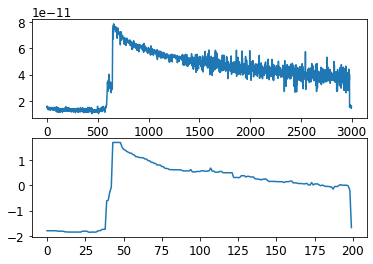

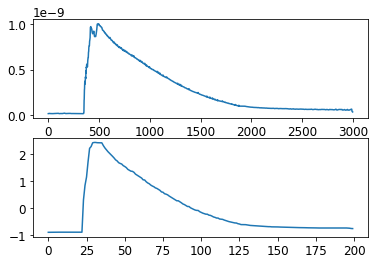

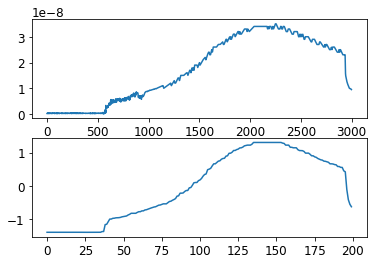

In [141]:
for i in range(3):
    plt.subplot(2,1,1)
    plt.plot(range(3000),X_train_[i])
    plt.subplot(2,1,2)
    plt.plot(X_norm[i])
    plt.show()
    

In [188]:
%run imports/VacuumGauge_functions.ipynb
keras.backend.clear_session()
from scipy.signal import medfilt, savgol_filter


def build_CNN(layers=1, filters=32, kernel_size=10):
    
    model = keras.models.Sequential()
    model.add(keras.layers.Reshape((3000, 1), input_shape=[3000]))
    model.add(keras.layers.MaxPool1D(pool_size=15, strides=15, padding='same'))
    # model.add(keras.layers.Lambda(lambda X: preprocess(X)))
    model.add(KerasPreprocess())
    model.add(keras.layers.Reshape(( 200, 1)))


    for layer in range(layers):
        model.add(keras.layers.Conv1D(filters=filters, kernel_size=kernel_size,
                                      activation='relu', strides=1, input_shape = [None, 1],
                                      padding='same', use_bias=True, kernel_initializer='he_normal',
                                      ))
        model.add(keras.layers.MaxPool1D(pool_size=2, padding='same'))

    
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(units=1, activation='sigmoid'))

    # learning_rate = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.1,
    #                                                             decay_steps= batch_size ,
    #                                                             decay_rate=0.1)
    optimizer = keras.optimizers.Nadam(learning_rate=1e-5)

    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=keras.metrics.binary_accuracy)
    return model

model = build_CNN(layers=1, filters=5, kernel_size=20 )
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 3000, 1)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 200, 1)            0         
_________________________________________________________________
keras_preprocess (KerasPrepr (None, None, None)        0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 200, 1)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 200, 5)            105       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 100, 5)            0         
_________________________________________________________________
flatten (Flatten)            (None, 500)               0

In [173]:
epochs = 400
run_log_dir = get_run_logdir('cnn')
tensorboard_cb = keras.callbacks.TensorBoard(run_log_dir)
#model.run_eagerly = False
history = model.fit(X_train, y_train,
                    epochs=epochs, verbose=1, batch_size=32,
                    validation_data=(X_test, y_test),
                    callbacks=[tensorboard_cb])

Epoch 1/400
6/6 [==============================] - 0s 76ms/step - loss: 1.0705 - binary_accuracy: 0.4880 - val_loss: 0.9744 - val_binary_accuracy: 0.4911
Epoch 2/400
6/6 [==============================] - 0s 31ms/step - loss: 1.0640 - binary_accuracy: 0.4880 - val_loss: 0.9676 - val_binary_accuracy: 0.4911
Epoch 3/400
6/6 [==============================] - 0s 28ms/step - loss: 1.0567 - binary_accuracy: 0.4880 - val_loss: 0.9609 - val_binary_accuracy: 0.5000
Epoch 4/400
6/6 [==============================] - 0s 36ms/step - loss: 1.0494 - binary_accuracy: 0.4880 - val_loss: 0.9536 - val_binary_accuracy: 0.5000
Epoch 5/400
6/6 [==============================] - 0s 31ms/step - loss: 1.0417 - binary_accuracy: 0.4880 - val_loss: 0.9461 - val_binary_accuracy: 0.5000
Epoch 6/400
6/6 [==============================] - 0s 41ms/step - loss: 1.0338 - binary_accuracy: 0.4880 - val_loss: 0.9384 - val_binary_accuracy: 0.5000
Epoch 7/400
6/6 [==============================] - 0s 46ms/step - loss: 1.02

In [ ]:
#early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch/s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=1e-5, s=-17)    
epochs = 500
run_log_dir = get_run_logdir('cnn')
tensorboard_cb = keras.callbacks.TensorBoard(run_log_dir)  

lr = [exponential_decay_fn(epoch) for epoch in range(100)]
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
epochs = 100
class_weight = {0: 1.,
                1: 1.}
history = model.fit(X_train, y_train,
                    epochs=epochs, verbose=1, class_weight=class_weight,
                    validation_data=(X_test, y_test),
                    callbacks= [lr_scheduler, tensorboard_cb])

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(lr, history.history['val_loss'])
plt.xlim(1e-5, 1e-1)
plt.xscale('log')
plt.show()

In [ ]:
y_true = y_test
y_pred = model.predict_classes(X_test)
m = keras.metrics.Recall()
m.update_state(y_true, y_pred)
m.result()

In [ ]:
a = [0, 0, 1.2, 0.8]
b = [1, 1, 1, 1] 
keras.metrics.Accuracy()(tf.round(a),tf.round(b))

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
y_pred = grid_search.best_estimator_.predict(X_test)

# y_pred = np.round(y_pred)
print(accuracy_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(precision_score(y_test, y_pred))

In [190]:
cnn_clf = keras.wrappers.scikit_learn.KerasClassifier(build_CNN)

model = cnn_clf
model_dir = 'data/models/cnn'
model_version = 'cnn_002.h5'
model_csv = 'cnn_002.csv'
scoring = ['recall', 'accuracy', 'precision']


In [191]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'layers': [1],
     'filters' : [10, 50, 100], #train batte validation con filter >5. Esecuzione normale con filter =5 layer =1
    }
]

In [195]:
keras.backend.clear_session()

print("# Tuning hyper-parameters for {} and {}".format(scoring[0], scoring[1]))
print()
grid_search = GridSearchCV(
    estimator=model, 
    param_grid=param_grid, 
    scoring=scoring,
    n_jobs=-1,
    verbose=2, 
    cv=strat_kfold, 
    return_train_score=True,
    refit=scoring[1]  ## Score used for final refit
)

grid_search.fit(X, y, epochs=30)

# Tuning hyper-parameters for recall and accuracy

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   58.3s finished
Epoch 1/30
9/9 [==============================] - 0s 25ms/step - loss: 0.6059 - binary_accuracy: 0.6835
Epoch 2/30
9/9 [==============================] - 0s 18ms/step - loss: 0.5528 - binary_accuracy: 0.7410
Epoch 3/30
9/9 [==============================] - 0s 21ms/step - loss: 0.5024 - binary_accuracy: 0.7806
Epoch 4/30
9/9 [==============================] - 0s 19ms/step - loss: 0.4574 - binary_accuracy: 0.8273
Epoch 5/30
9/9 [==============================] - 0s 19ms/step - loss: 0.4201 - binary_accuracy: 0.8561
Epoch 6/30
9/9 [==============================] - 0s 19ms/step - loss: 0.3884 - binary_accuracy: 0.8813
Epoch 7/30
9/9 [==============================] - 0s 19ms/step - loss: 0.3623 - binary_accuracy: 0.8813
Epoch 8/30
9/9

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score='raise-deprecating',
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x164f2b208>,
             iid='warn', n_jobs=-1,
             param_grid=[{'filters': [10, 50, 100], 'layers': [1]}],
             pre_dispatch='2*n_jobs', refit='accuracy', return_train_score=True,
             scoring=['recall', 'accuracy', 'precision'], verbose=2)

In [182]:
printGridSearchResults(grid_search, scoring[1])

Best parameters set found on development set:
{'filters': 20, 'layers': 1}

Grid scores on development set:

0.939 (+/-0.048) for {'filters': 20, 'layers': 1}


In [ ]:
grid_search.best_estimator_.model

In [196]:
cv_result = pd.DataFrame(grid_search.cv_results_)


In [197]:
cv_result.to_csv(os.path.join(model_dir, model_csv),  index=False)

## RBF

In [ ]:
df_raw = pd.read_csv('data/datasets/df_raw.csv')
df_raw = df_raw[df_raw.fillNumber != 2011]

df_raw = df_raw.astype({'fillNumber': 'int'})
df_raw = df_raw.set_index(['gauge_id','fillNumber'], drop=True)
df_raw.index.get_level_values('fillNumber').value_counts()


kmeans_centers_path = 'data/datasets/k12_centers.npy'
silhouette_scores_path = 'data/datasets/silhouette_scores_range_2_20.npy'
inertias_path = 'data/datasets/intertias_range_2_20.npy'

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

scaler = RowScaler(scaling_method='Standard')
Xu_scaled = scaler.fit_transform(df_raw)

In [ ]:
if os.path.exists(kmeans_centers_path):
    k12_centers = np.load(kmeans_centers_path)
    print('KMeans center loaded.')
else:
    print('Recomputing KMeans...')
    kmeans_per_k = [KMeans(n_clusters=k,
                                    algorithm='elkan',
                                    random_state=42,
                                    n_jobs=-1,
                                    verbose=2
                                    ).fit(X_scaled)
                    for k in range(2, 20)]
    k12_centers = np.array(kmeans_per_k[12 -2].cluster_centers_)
    np.save('data/datasets/k12_centers.npy', k12_centers)



if os.path.exists(inertias_path):
    inertias = np.load(inertias_path)
    print('inertias loaded.')
else:
    inertias = [model.inertia_ for model in kmeans_per_k]
    np.save(inertias_path, inertias)
    print('inertias saved.')

if os.path.exists(silhouette_scores_path):
    silhouette_scores = np.load(silhouette_scores_path)
    print('silhouette loaded')
else:
    silhouette_scores = [silhouette_score(X_scaled, model.labels_)
                         for model in kmeans_per_k]
    np.save(silhouette_scores_path, silhouette_scores)
    print('silhouette saved')

In [ ]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(2, 20), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.grid(False)
plt.show()

In [ ]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 20), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.xlim(10,15)
plt.ylim(0.16, 0.19)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()

In [ ]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (10, 11, 12, 13):
    plt.subplot(2, 2, k - 9)
    
    y_pred = kmeans_per_k[k - 2].labels_
    silhouette_coefficients = silhouette_samples(X_scaled, y_pred)

    padding = len(X_scaled) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (10, 12):
        plt.ylabel("Cluster")
    
    if k in (12, 13):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)


plt.show()

In [ ]:
len(kmeans_per_k[12 -2].cluster_centers_)
k12_centers.shape

In [ ]:
k12_centers = np.load('data/datasets/k12_centers.npy')
for c in k12_centers:
    plt.plot(range(3000), c)
    plt.show()

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances

d_max = np.max(euclidean_distances(k12_centers, k12_centers))
keras.backend.clear_session()
model = keras.models.Sequential()
model.add(keras.layers.Lambda(lambda X: rowScale(X), input_shape=[3000]))
model.add(RBFLayer(12,
                    initializer=InitFromFile('data/datasets/k12_centers.npy'),
                    betas=d_max/np.sqrt(len(k12_centers)),
                    trainable=False,
                    input_shape=[3000])
                    )
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.add(keras.layers.Lambda(lambda X: tf.round(X)))

optimizer = keras.optimizers.Adam()

model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=[keras.metrics.Recall()])

model.summary()
model.get_weights()

In [ ]:
history = model.fit(X, y, epochs=5, validation_split=0.33, verbose=1)
y_pred = model.predict(X[-50:])

In [ ]:
y_pred

In [ ]:
11 // 2

domande:
devo abilitare il training sul layer RBF? iniziamo senza farlo
definire modelli finali: pca solo su training, kmeans su tutto unlabelled
train - val- test split, va bene? No usiamo solo k fold
quante fold nel k fold? meglio 10
perche RNN cosi lenta?